# Classification - Decision Trees

<div class="alert alert-block alert-info">

## Learning Objectives

- Understand the principles of classification and differentiate logistic regression from decision trees.  
- Train and evaluate models using metrics like accuracy, precision, recall, and F1-score.  
- Interpret the coefficients of logistic regression and the structure of decision trees.  
- Identify and mitigate overfitting using regularization (logistic regression) and pruning (decision trees).  
- Compare and select models based on interpretability, complexity, and real-world applications.
</div>

First let's import the packages that we need for this notebook.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Decision Trees

Let's assume that you have more than two classes for prediction. For example, we might want to predict `ChestPainType`. We can turn to other models that can handle two or more classes for classification. One such example is the Decision Tree Classifier. In terms of logic, this is like a flow chart.

In this flow chart the data is that the lamp doesn't work, and the features are information about how the lamp doesn't work. The classes is the action that is taken at the end.

![Alt](https://upload.wikimedia.org/wikipedia/commons/9/91/LampFlowchart.svg)

While the ultimate goal of classification remains the same, machine learning algorithms vary widely in terms of *how* they go about this task. The neat thing about `sklearn` is that many algorithms use the same syntax, which makes comparing their performance on a task fairly straightforward. However, each model will have different underlying parameters and methods to identify the optimal split. When you are using a new model it is helpful to read up on how the model works. 

The documentation is a great way to do that.
Read the [documentation](https://scikit-learn.org/stable/modules/tree.html#tree) for the Decision Tree and let's try to answer the following questions:

1. What are two advantages and two disadvantages of the Decision Tree?
2. What measure do Decision Trees use to determine optimal split?
3. How do you import the Decision Tree from sklearn?

**Decision Trees** are a classification/regression supervised learning algorithm that uses a series of splits to make its predictions.

Decision Trees learn from the data by picking the feature-threshold that maximizes the information gain of the target variable. In other words it chooses a splitting point that produces the most imbalanced/pure proportions in the target variable. The goal of the model is to keep splitting until all the data in a terminal node or leaf are exclusively one class.

The model iterates through a set of values for each feature and then calculate the information gain for each split and the one that produces the lowest value is the designated split.

**Parameters**

There are many [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for the Decision Tree Classifier. A few relevant to this notebook are described here:

**criterion**: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**splitter**: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

**max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split**: The minimum number of samples required to split an internal node

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

**max_features**: The number of features to consider when looking for the best split

In [3]:
data = pd.read_csv('../data/heart.csv')
# Check out the first few rows
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
y = data['ChestPainType']
X = data.drop('ChestPainType', axis =1)
X.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,130,283,0,ST,98,N,0.0,Up,0
3,48,F,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
data['RestingBP'].replace(0, np.nan, inplace=True)
data['Cholesterol'].replace(0, np.nan, inplace=True)

In [7]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.20, stratify=y)
print(X_train.shape)

(734, 11)


In [12]:
# Get the categorical and numerical variable column indices
cat_var = ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']
num_var = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# Splice the training array
X_train_cat = X_train[cat_var]
X_train_num = X_train[num_var]

# Splice the test array
X_test_cat = X_test[cat_var]
X_test_num = X_test[num_var]

In [13]:
imputer = SimpleImputer(missing_values=np.nan,
                        strategy='mean', 
                        copy=True)
# Impute the data
X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp = imputer.transform(X_test_num)

In [15]:
import warnings
warnings.filterwarnings('ignore')
dummy_e = OneHotEncoder(categories='auto', drop='first', sparse=False)

# Categorical feature encoding
X_train_dummy = dummy_e.fit_transform(X_train_cat)
X_test_dummy = dummy_e.transform(X_test_cat)

In [17]:
X_train = np.hstack((X_train_dummy, X_train_imp))
X_test = np.hstack((X_test_dummy, X_test_imp))

X_train.shape, X_test.shape

((734, 13), (184, 13))

In [46]:
dummy_columns = dummy_e.get_feature_names_out()
dummy_columns_list = dummy_columns.tolist()
column_name = dummy_columns_list + num_var

In [47]:
X_train = pd.DataFrame(X_train)
X_train.columns = column_name

X_test = pd.DataFrame(X_test)

X_test.columns = column_name
y_train = pd.DataFrame(y_train)
y_train.columns = ['ChestPainType']

y_test = pd.DataFrame(y_test)
y_test.columns = ['ChestPainType']

Now let's train a decision tree model on the hearts data set. We are going to start with a default DT model, meaning we're not going to pass in any parameters of our own. Like we did before, we are going to fit a model and then evaluate it on the training and testing datasets. Let's start with a single x-feature.

In [48]:
# Initialize model
dt = DecisionTreeClassifier()

# Fit model on the dataset
dt.fit(X_train[['MaxHR']], y_train['ChestPainType'])

# Derive the training accuracy score
dt.score(X_train[['MaxHR']], y_train['ChestPainType'])

0.6253405994550408

In [49]:
# Test score
dt.score(X_test[['MaxHR']], y_test['ChestPainType'])

0.5597826086956522

**Question:** Our testing score is considerably lower. When the testing score is lower than the training score, what does that mean?

We can take advantage of some of the parameters of the decision tree in order to help prevent overfitting of the model. Let's try a model in which we impose some constraints on the tree?

**Question:** From the documentation, what is one parameter that might help?

In [66]:
# Initialize
dt = DecisionTreeClassifier(max_depth=5)
# Fit 
dt.fit(X_train[['MaxHR']], y_train['ChestPainType'])

# Evaluate
train_score = dt.score(X_train[['MaxHR']], y_train['ChestPainType'])
test_score = dt.score(X_test[['MaxHR']], y_test['ChestPainType'])

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.584 and our testing score is 0.582


The gap between the two scores is considerably lower. Arguably we don't have an over fit model anymore. However, we could likely improve on the accuracy of this model by including more features.

### Tree Visualization

One big advantage of the Decision Tree is that it can be visualized no matter how many features were involved.

Let's retrain it with a small `max_depth` 

In [70]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train[['MaxHR']], y_train['ChestPainType'])

DecisionTreeClassifier(max_depth=2)

**Question:** What is the first criteria used to split the decision tree? 

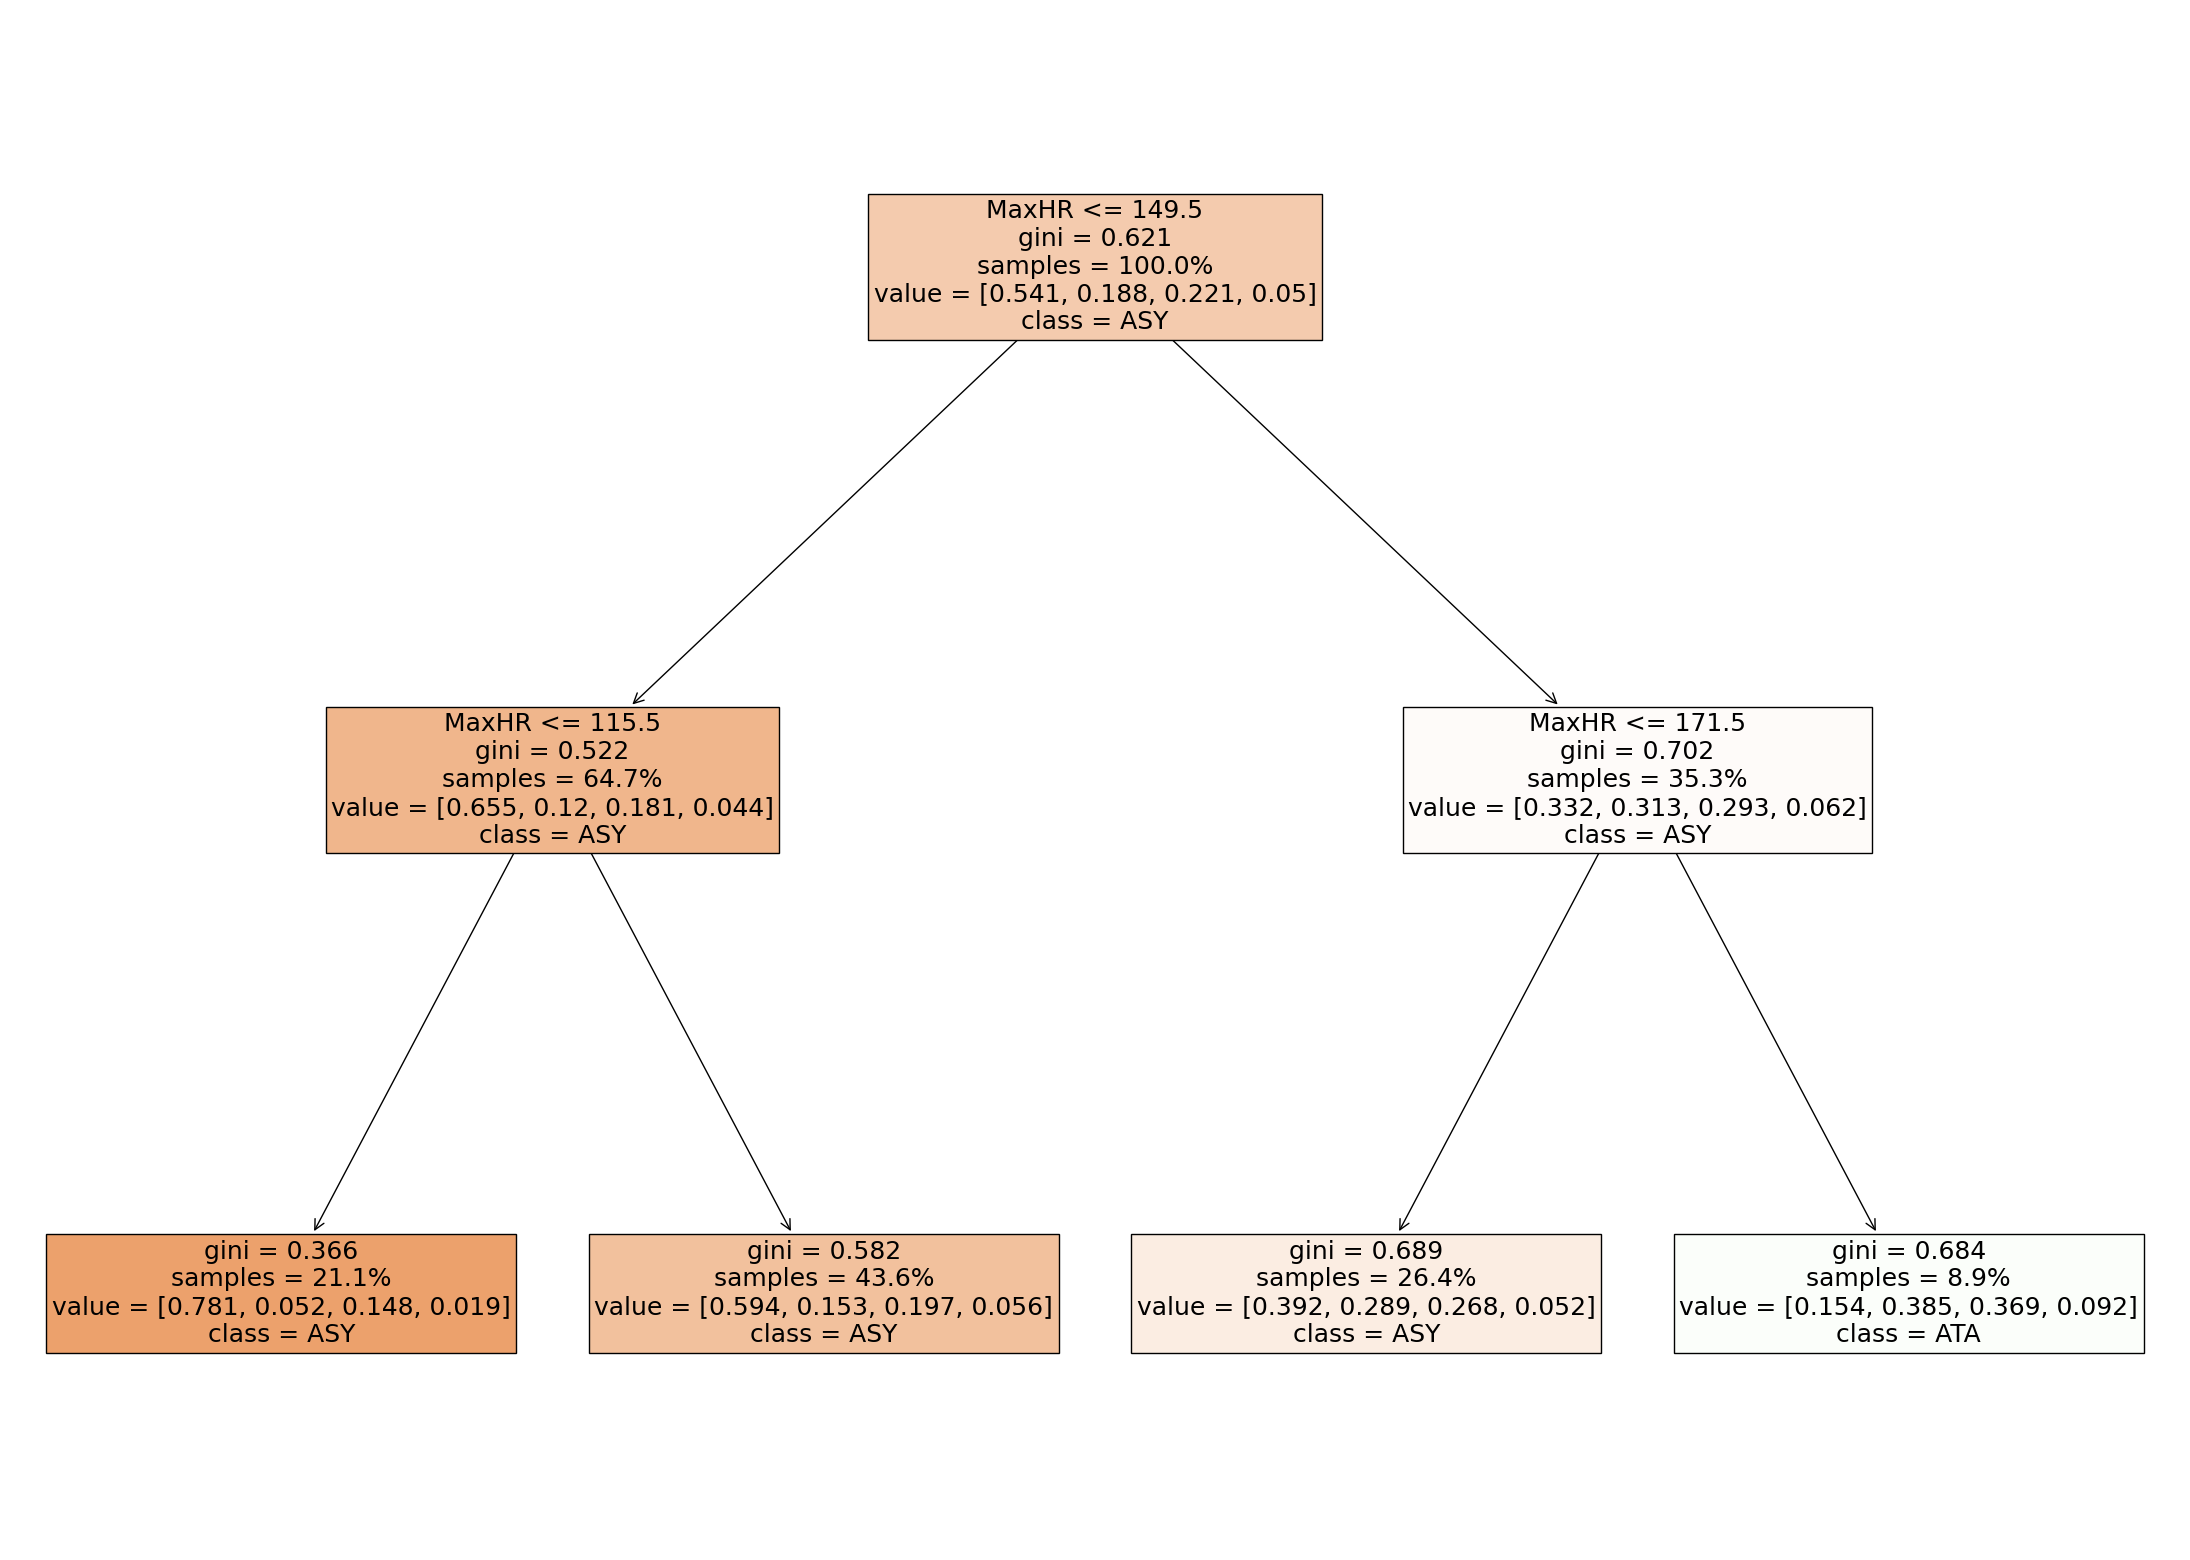

In [71]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=['MaxHR'], class_names=dt.classes_, 
          filled = True, proportion=True, fontsize=18
         );

In [74]:
# Initialize
dt = DecisionTreeClassifier(max_depth=2)
# Fit 
dt.fit(X_train, y_train['ChestPainType'])

# Evaluate
train_score = dt.score(X_train, y_train['ChestPainType'])
test_score = dt.score(X_test, y_test['ChestPainType'])

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.604 and our testing score is 0.603


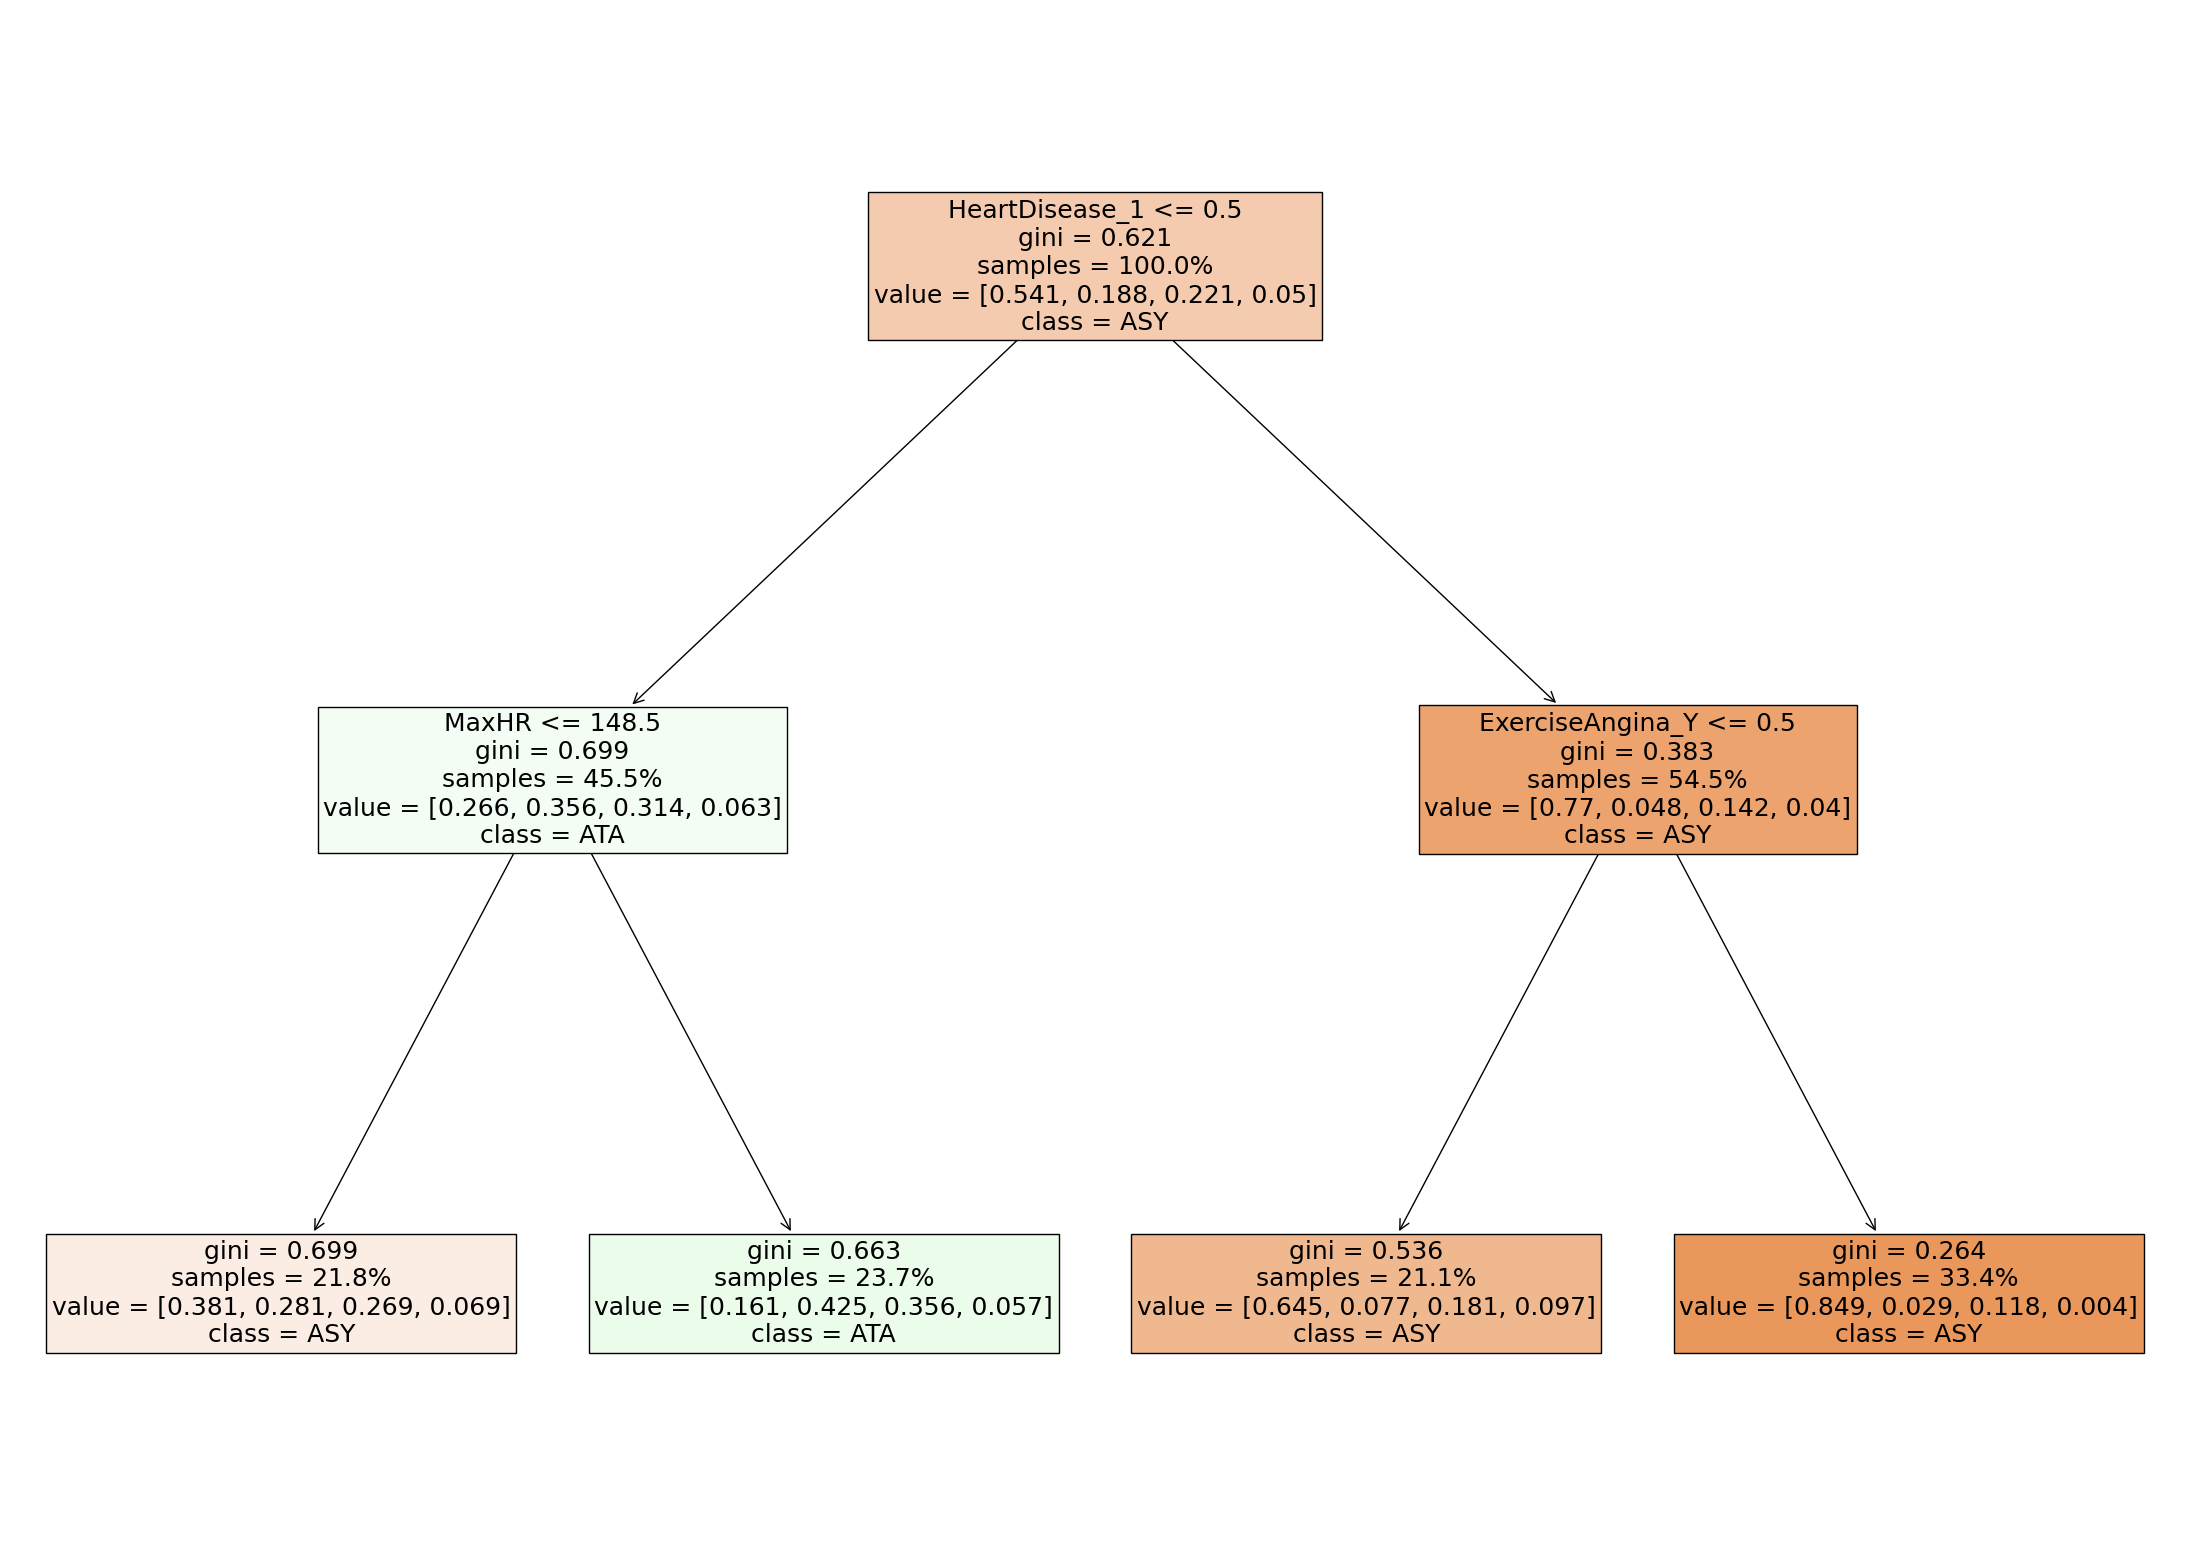

In [75]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=dt.feature_names_in_, class_names=dt.classes_, 
          filled = True, proportion=True, fontsize=18
         );

## Challenge 2: Classification with SVM

Now let's try another new model. The [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html#classification) is another class of machine learning algorithm that is used for classification. 

Choose two features of the data set to train your model on. Then, using the documentation for the support vector machine, follow the steps to:
- Initialize the model
- Fit it to the training data
- Evaluate the model on both the training and testing data

Is your model underfit? Is it overfit?

How does SVM fit in with the **linearly separable** problem identified in the scatter plots above?

In [77]:
## YOUR CODE HERE
from sklearn.svm import SVC
X_train_subset = X_train[['feature1','feature2']]
X_test_subset = X_test[['feature1','feature2']]
y_train_subset = y_train['ChestPainType']
y_test_subset = y_test['ChestPainType']

##1) Initialize SVM

##2) Train SVM on Training data 

##3) Evaluate SVM on Training and Test Data

0.5408719346049047
0.5380434782608695
